# Statistická práce

## Použitá data

Jako dataset používám dataset "ilc_di08" z Eurostatu, který obsahuje informace o mediánovém a průměrném ročním příjmu v závislosti na:
- zemi (evropské státy)
- roce (2005 - 2023)
- úrovni vzdělání (ED0-2, ED3-4, ED5-8 podle ISCED)
- věkové skupině (plánuji se zaměřit na 18–64 let)
- pohlaví

Státy:
- `CZ` - Česká republika
- `DE` - Německo
- `EU` - Evropa, průměr
- `UK` - Velká Británie
- `CH` - Švýčarsko
- `SE` - Srbsko
- `HU` - Maďarsko
- etc.

Úrovně vzdělání:
- `ED0-2` - Early childhood education - Lower secondary education
- `ED3_4` - Upper secondary education - Post-secondary non-tertiary education
- `ED5-8` - Short-cycle tertiary education - Doctoral or equivalent level

Věkové skupiny:
- `Y18-64` - od 18 do 64 let
- `Y_GE18` - od 18 let
- `Y_GE65` - od 65 let

Pohlaví:
- `F` - ženy
- `M` - muži
- `T` - všichni

Příjem:
- `MED_E` - průměrný
- `MEI_E` - mediánový

Měny:
- `EUR` - eura
- `NAC` - měna zemi
- `PPS` - pps

## Popis zadání

Chtěl bych zjistit, jak silně koreluje úroveň vzdělání s příjmem v různých zemích (např. Česko, Německo, EU průměr) a jak se tato korelace vyvíjí v čase.

Plánovaná metodologie: Lineární regrese.

Také bych chtěl otestovat hypotézu, zda výše vzdělání hraje v příjmu větší roli v bohatších částech Evropy (např., Německo, Svýčarsko a Dansko), než v chudších částech Evropy (např., Maďarsko, Srbsko a Česká republika).

## Knihovny

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Read data

In [2]:
df = pd.read_csv("../data/estat_ilc_di08.tsv", sep="\t", na_values=": ")

## Lineární regrese

### Common

In [76]:
education_mapping = {
    "ED0-2": 1,
    "ED3_4": 2,
    "ED5-8": 3,
}

def do_statistics(country, country_code):
    # list of row identifiers
    keys = [
        f"A,MEI_E,EUR,ED0-2,T,Y18-64,{country_code}",
        f"A,MEI_E,EUR,ED3_4,T,Y18-64,{country_code}",
        f"A,MEI_E,EUR,ED5-8,T,Y18-64,{country_code}",
    ]

    first_col = df.columns[0]

    # filter dataframe for these first-column values
    df_filtered = df[df[first_col].isin(keys)]

    df_filtered = df_filtered.copy()
    df_filtered[first_col] = df_filtered[first_col].str.split(",").str[3].map(education_mapping)
    df_filtered.rename(columns={first_col: "education"}, inplace=True)

    df_triples = df_filtered.melt(id_vars="education", var_name="year", value_name="value").dropna(subset=["value"])

    # convert year and value to integers
    df_triples["year"] = df_triples["year"].astype(int)
    df_triples["value"] = df_triples["value"].map(lambda x: x.split()[0]).astype(int)

    # prepare feature matrix x and target vector y as integer arrays
    x = df_triples[["education", "year"]].values
    y = df_triples["value"].values

    model = LinearRegression(n_jobs=-1).fit(x, y)
    print(f"Coefficients (Education level, Year): {model.coef_}")

    # 1. Predicted vs actual average salary
    min_val = df_triples["value"].min()
    max_val = df_triples["value"].max()
    plt.figure(figsize=(14, 8))
    for edu in sorted(df_triples["education"].unique()):
        df_edu = df_triples[df_triples["education"] == edu]
        x_edu = df_edu[["year"]].values
        y_edu = df_edu["value"].values
        model_edu = LinearRegression(n_jobs=-1).fit(x_edu, y_edu)
        y_pred_edu = model_edu.predict(x_edu)
        print(f"Coefficients (Year) for Education level {edu}: {model_edu.coef_}")
        plt.scatter(y_edu, y_pred_edu, label=f"Education - {edu}")
    plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Perfect Fit")
    plt.xlabel("Actual salary, EUR")
    plt.ylabel("Predicted salary, EUR")
    plt.title(f"Regression: Actual vs Predicted salavy by Education Level, {country}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Average salary over years for each education level
    df_avg = df_triples.groupby(["year", "education"])["value"].first().unstack("education")
    plt.figure(figsize=(14, 8))
    for edu in df_avg.columns:
        plt.plot(df_avg.index, df_avg[edu], marker="o", label=f"Education - {edu}")
    plt.xlabel("Year")
    plt.ylabel("Average salary, EUR")
    plt.title(f"Average salary by Year and Education level, {country}")
    plt.legend()
    plt.xticks(df_avg.index)
    plt.grid(True)
    plt.show()

    # 3. Predict next 5 years salary for each education level
    max_year = df_triples["year"].max()
    future_years = list(range(max_year + 1, max_year + 6))
    plt.figure(figsize=(14, 8))
    for edu in df_avg.columns:
        preds = model.predict(np.array([[edu, yr] for yr in future_years]))
        plt.plot(future_years, preds, linestyle="--", marker="x", label=f"Education - {edu}")
    plt.xlabel("Year")
    plt.ylabel("Average salary, EUR")
    plt.title(f"Prediction of average salary, {country}")
    plt.xticks(future_years)
    plt.grid(True)
    plt.legend()
    plt.show()

### Česká republika

Coefficients (Education level, Year): [2805.125       495.13834586]
Coefficients (Year) for Education level 1: [389.16842105]
Coefficients (Year) for Education level 2: [496.07593985]
Coefficients (Year) for Education level 3: [600.17067669]


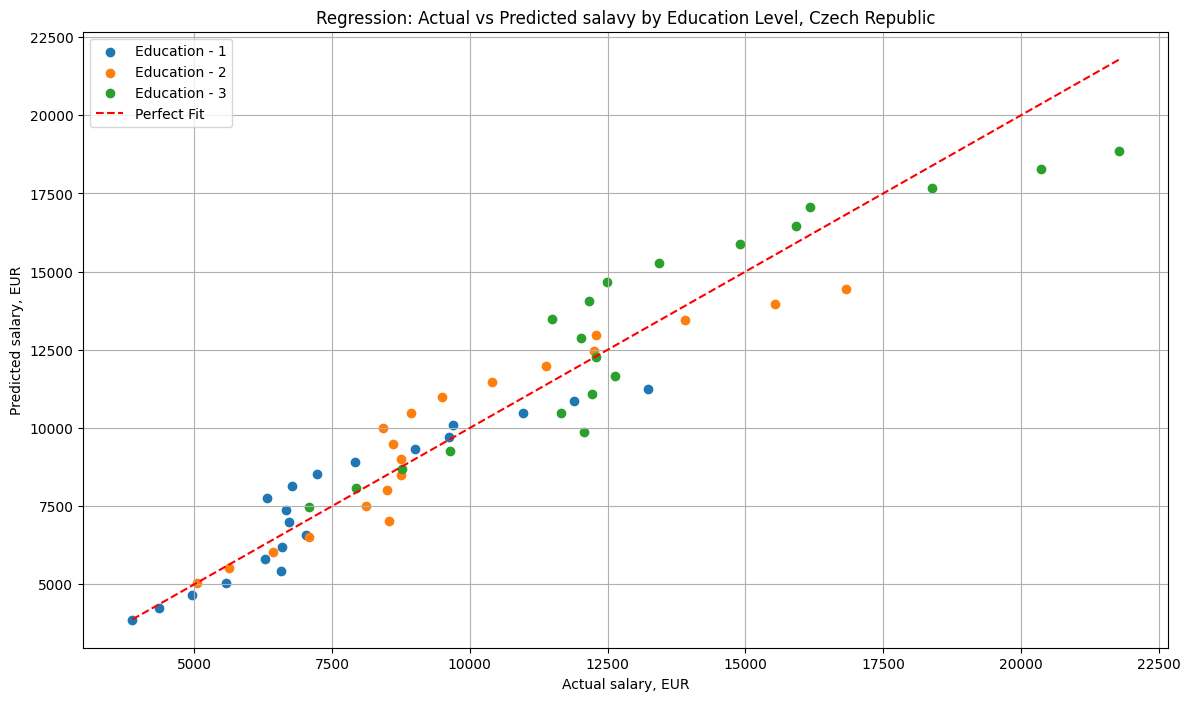

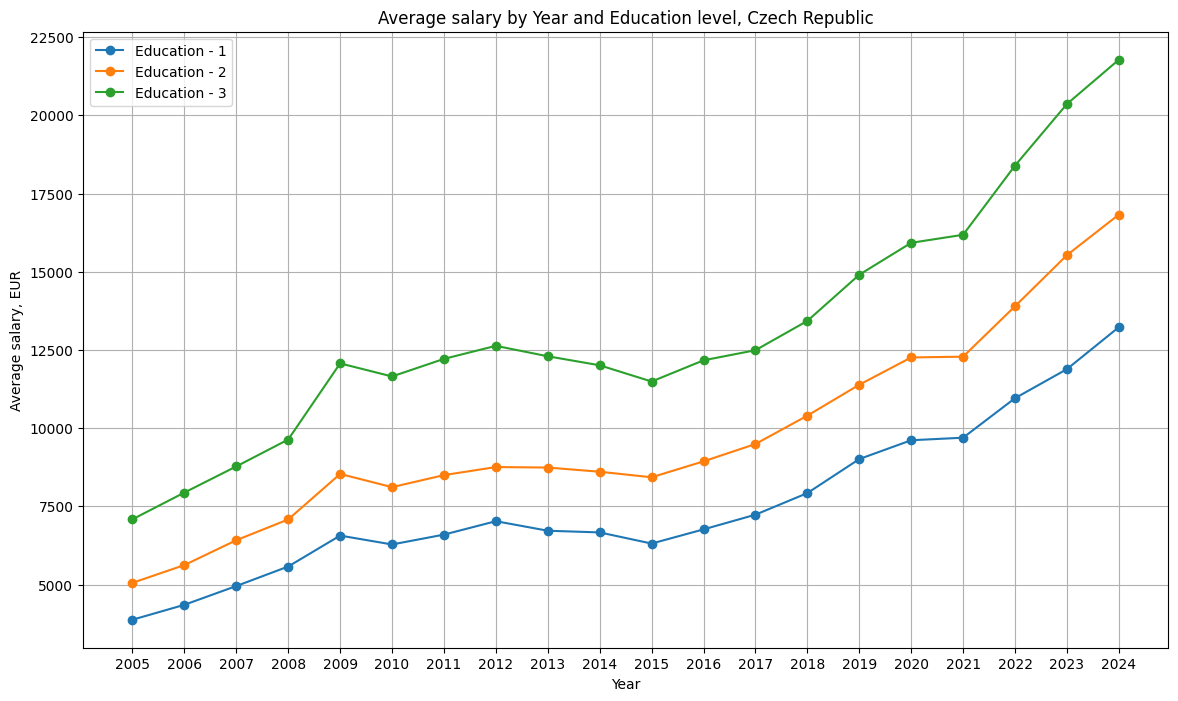

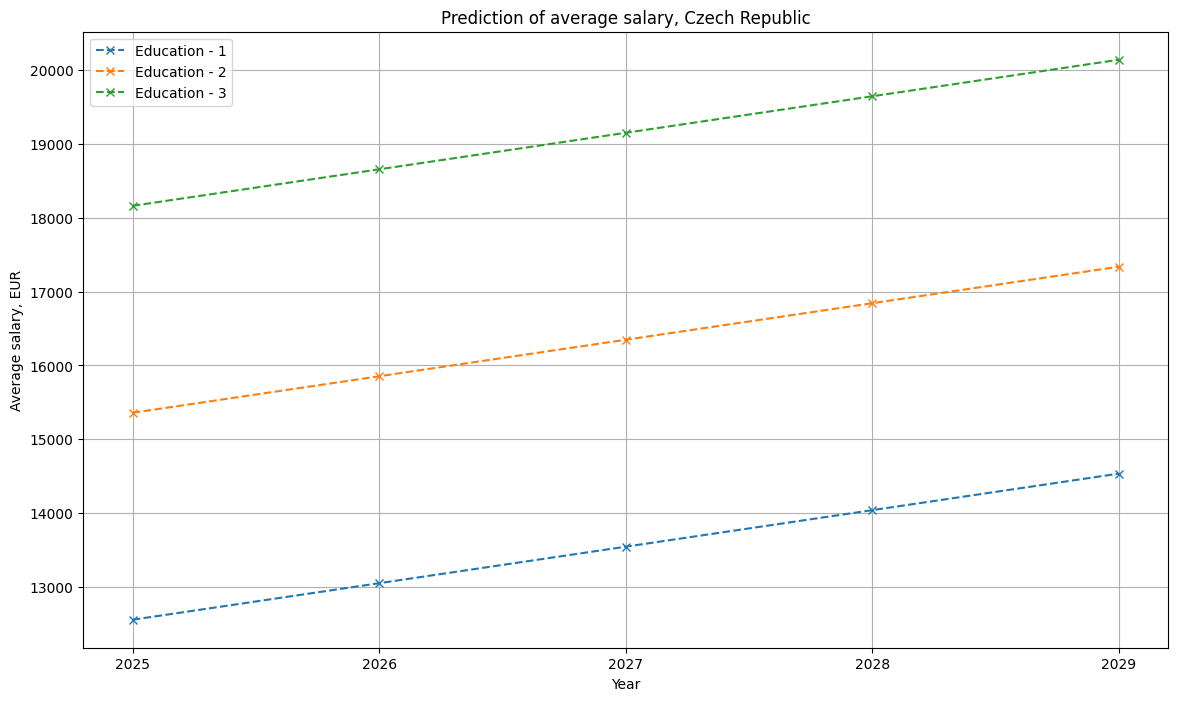

In [77]:
do_statistics("Czech Republic", "CZ")

### Německo

Coefficients (Education level, Year): [6286.7         646.94285714]
Coefficients (Year) for Education level 1: [404.23233083]
Coefficients (Year) for Education level 2: [624.27368421]
Coefficients (Year) for Education level 3: [912.32255639]


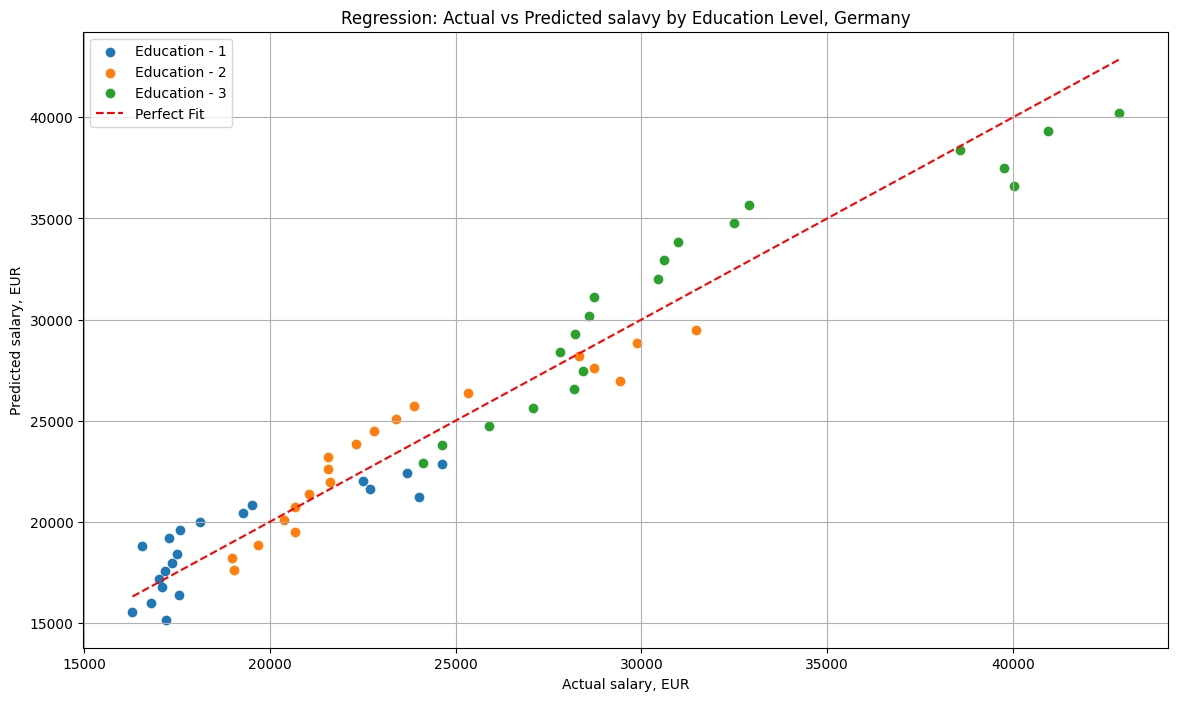

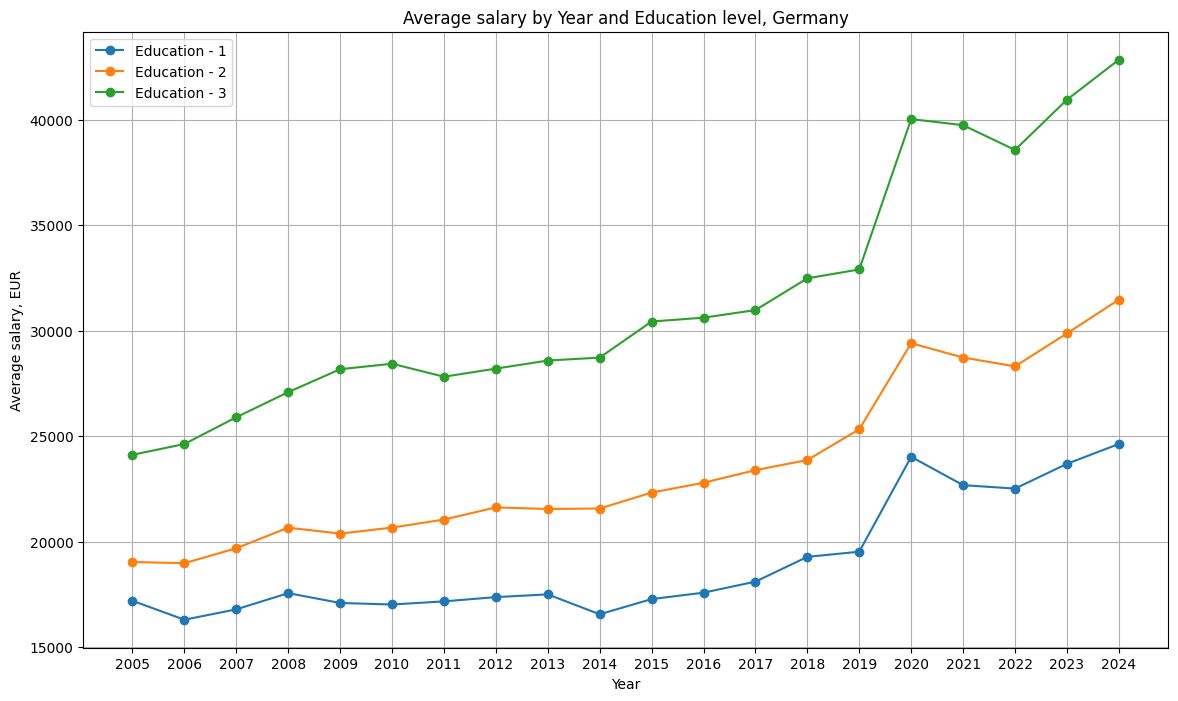

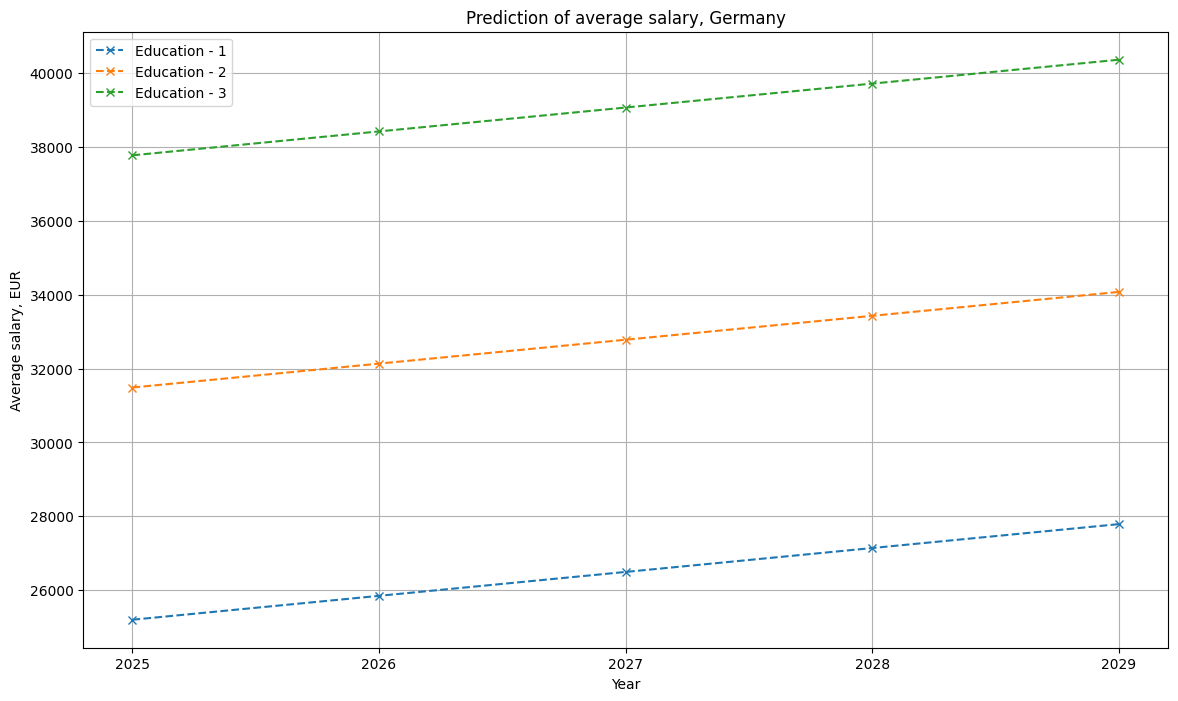

In [78]:
do_statistics("Germany", "DE")

### Evropa

Coefficients (Education level, Year): [5629.3         502.41904762]
Coefficients (Year) for Education level 1: [353.04285714]
Coefficients (Year) for Education level 2: [495.24642857]
Coefficients (Year) for Education level 3: [658.96785714]


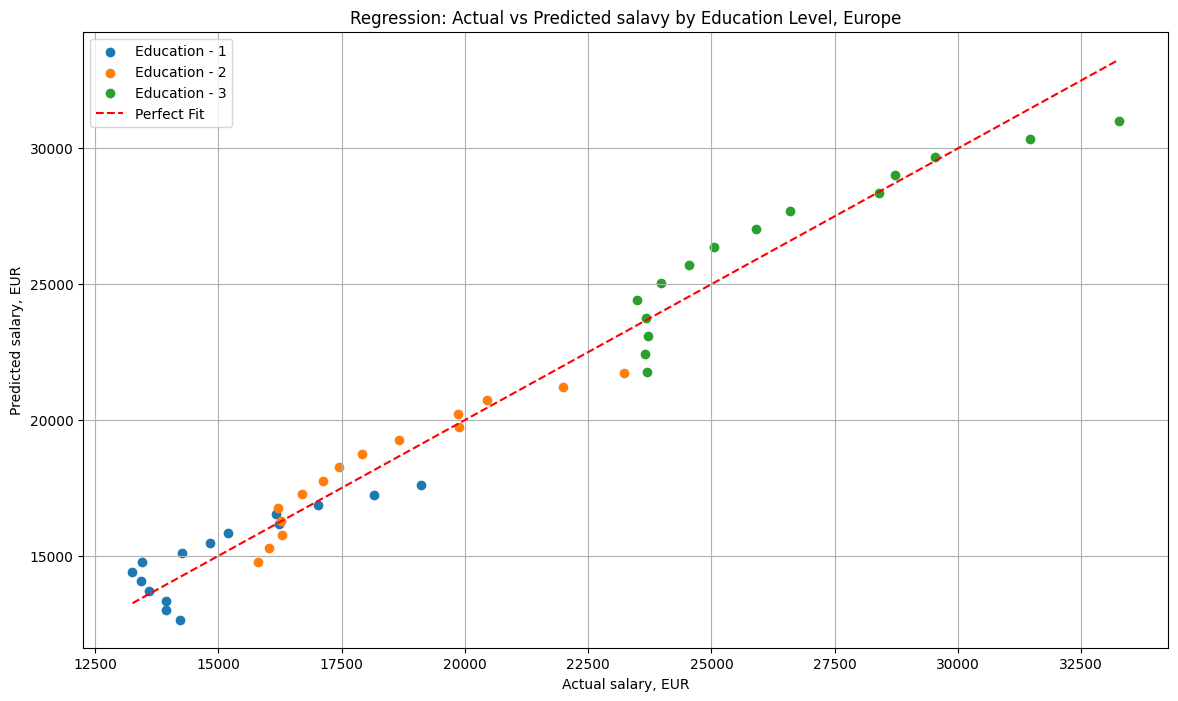

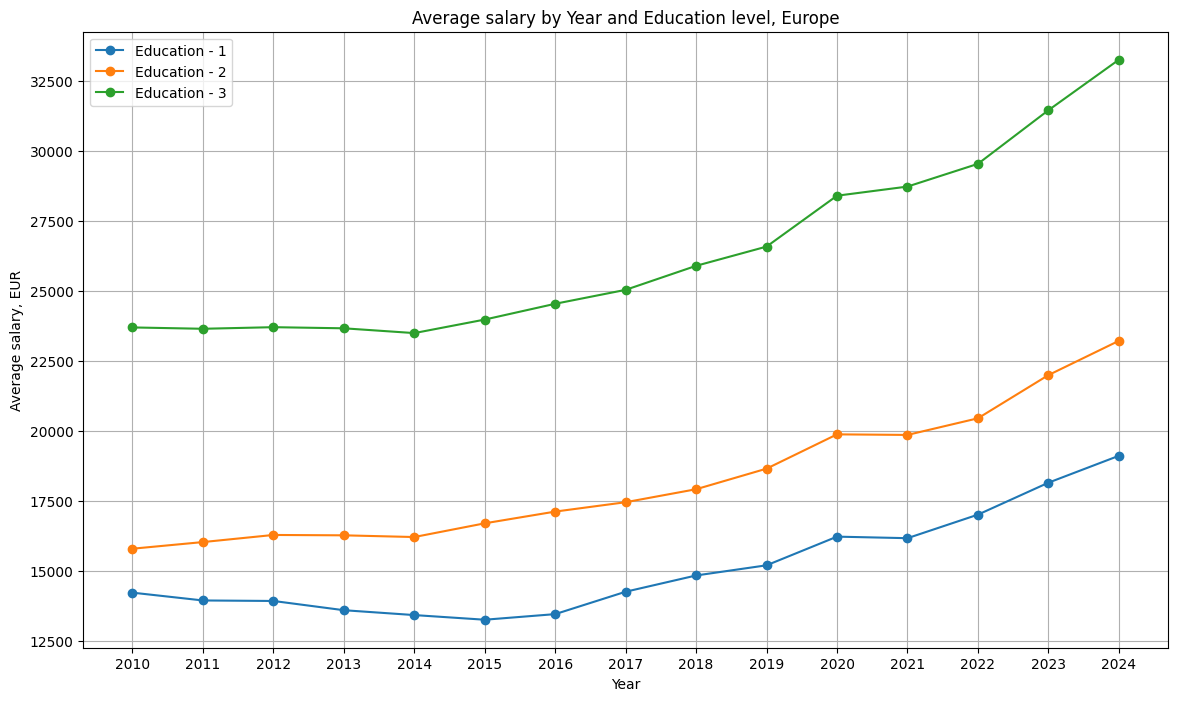

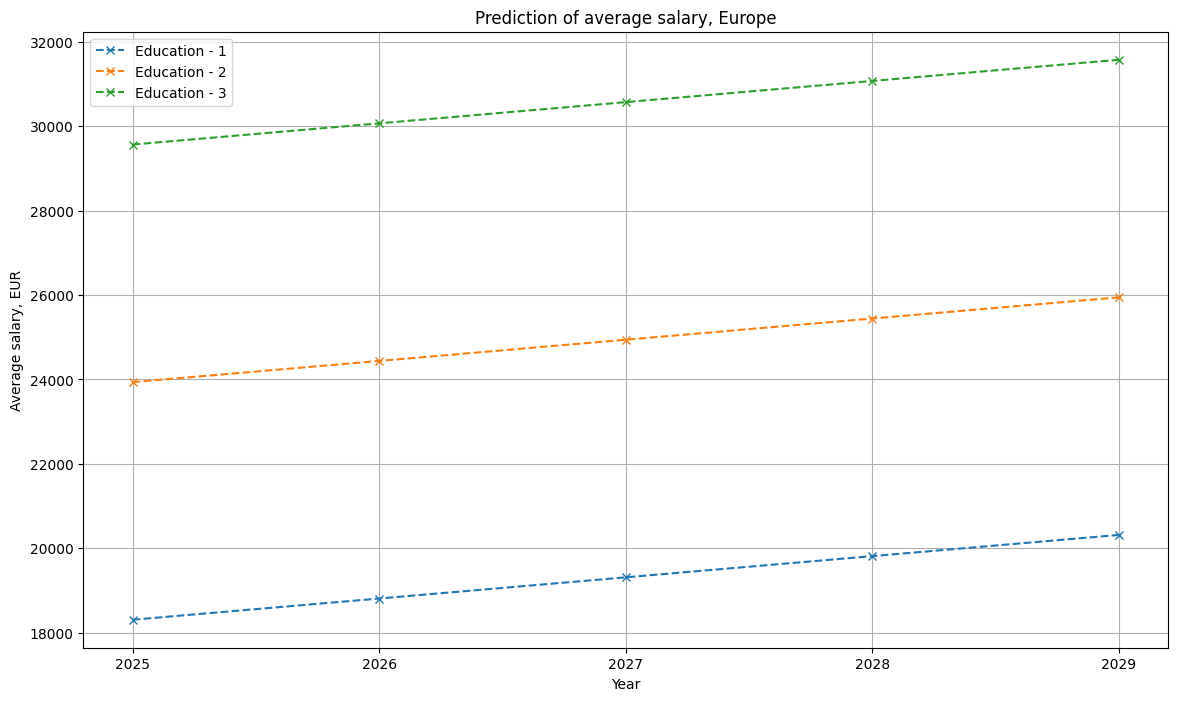

In [79]:
do_statistics("Europe", "EU27_2020")